In [18]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pandas as pd

def combine_files(r_file: Path, g_dir, b_dir, nir_dir, gt_dir):

        files = {'red': r_file,
                 'green':g_dir/r_file.name.replace('red', 'green'),
                 'blue': b_dir/r_file.name.replace('red', 'blue'),
                 'nir': nir_dir/r_file.name.replace('red', 'nir'),
                 'gt': gt_dir/r_file.name.replace('red', 'gt')}

        return files

base_path = Path('/root/.cache/kagglehub/datasets/sorour/38cloud-cloud-segmentation-in-satellite-images/versions/4/38-Cloud_training')
r_dir = base_path/'train_red'
g_dir = base_path/'train_green'
b_dir = base_path/'train_blue'
nir_dir = base_path/'train_nir'
gt_dir = base_path/'train_gt'

files = [combine_files(f, g_dir, b_dir, nir_dir, gt_dir) for f in r_dir.iterdir() if not f.is_dir()]

In [4]:
images = []
for idx in range(len(files)):
    raw_rgb = np.stack([np.array(Image.open(files[idx]['red'])),
                        np.array(Image.open(files[idx]['green'])),
                        np.array(Image.open(files[idx]['blue'])),
                        np.array(Image.open(files[idx]['nir'])),
                        np.array(Image.open(files[idx]['gt'])),
                        ], axis=0)
    images.append(raw_rgb)

images = np.array(images)

### Общая информация

In [5]:
print(f"Количество элементов датасета: {len(images)}")

Количество элементов датасета: 8400


In [6]:
print(f"Параметры изображения: {images[0].shape}")
print("Представлены 4 канала (red, green, blue, near IR) и истинная маска")

Параметры изображения: (5, 384, 384)
Представлены 4 канала (red, green, blue, near IR) и истинная маска


### Визуализация

In [7]:
def visualize(image):
    r = image[0]
    g = image[1]
    b = image[2]
    nir = image[3]
    gt = image[4]
    
    plt.figure(figsize=(25, 5))

    plt.subplot(1, 5, 1)
    plt.imshow(r, cmap='Reds')
    plt.title("Red band image")
    plt.axis("off")

    plt.subplot(1, 5, 2)
    plt.imshow(g, cmap='Greens')
    plt.title("Green band image")
    plt.axis("off")

    plt.subplot(1, 5, 3)
    plt.imshow(b, cmap='Blues')
    plt.title("Blue band image")
    plt.axis("off")

    plt.subplot(1, 5, 4)
    plt.imshow(nir, cmap='plasma')
    plt.title("NIR band image")
    plt.axis("off")

    plt.subplot(1, 5, 5)
    plt.imshow(gt, cmap='gray', vmin=0, vmax=255)
    plt.title("Original mask")
    plt.axis("off")

    plt.show()

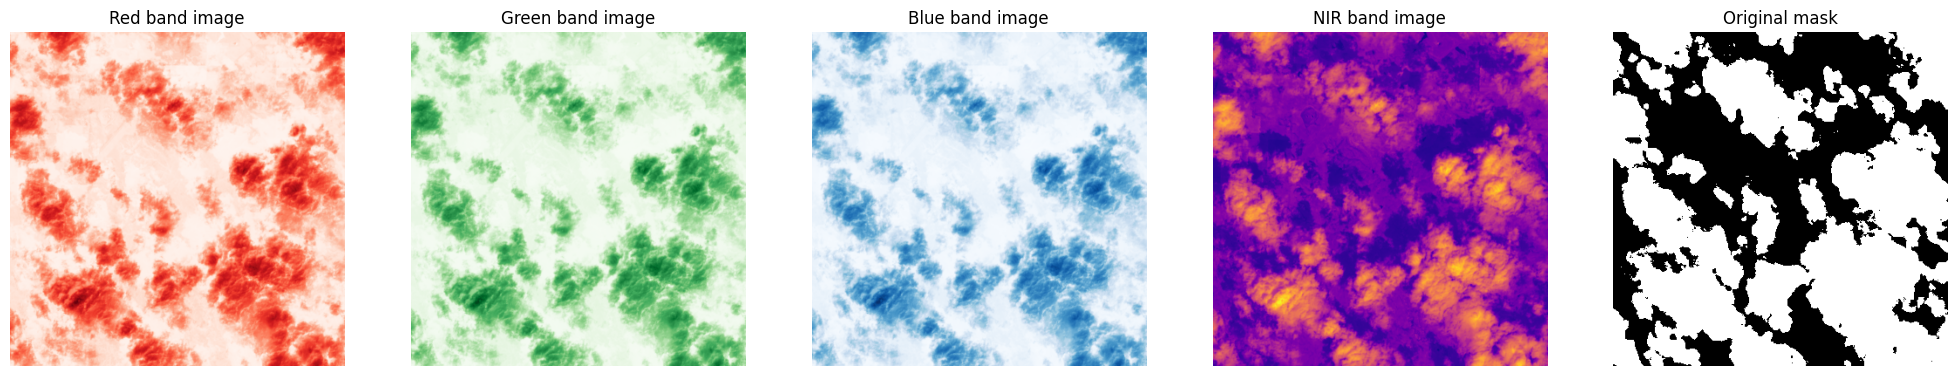

In [8]:
# Пример элемента датасета
visualize(images[4])

### Анализ изображений

In [33]:
# Проверка на пустые изображения
null_count = 0
images_informative = []
for image in images:
    if image.max() == 0:
        null_count += 1
    else:
        images_informative.append(image)

null_masks_perc = round(null_count/len(images)*100, 2)
        
print(f"{null_count}/{len(images)} ({null_masks_perc}%) пустых изображений")

2813/8400 (33.49%) пустых изображений


In [30]:
# Проверка, какая площадь занята ненулевыми пикселями на непустых изображениях
occupancy = []
for image in images_informative:
    rgbi = image[:4]
    nonzero_mask = np.any(rgbi != 0, axis=-1)
    occupied_pixels = np.sum(nonzero_mask)
    total_pixels = rgbi.shape[0] * rgbi.shape[1]
    fraction = occupied_pixels / total_pixels
    occupancy.append(fraction)

occupancy_perc = round(np.mean(occupancy) * 100, 2)

print(f'{occupancy_perc}% - средняя занятость изображения ненулевыми пикселями на непустых изображениях')

93.14% - средняя занятость изображения ненулевыми пикселями на непустых изображениях


(np.float64(-0.5), np.float64(383.5), np.float64(383.5), np.float64(-0.5))

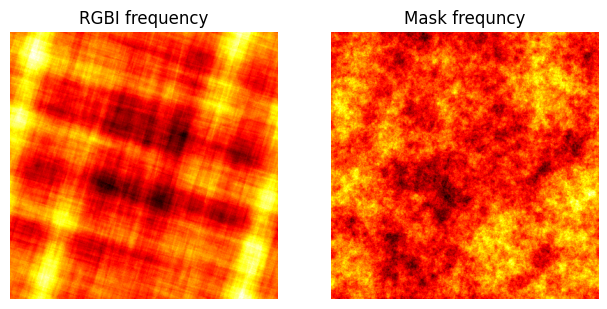

In [11]:
# Смотрим, где сосредоточены основные пиксели
pixel_location_rgbi = np.zeros_like(images_informative[0][0])
pixel_location_gt = np.zeros_like(images_informative[0][0])
for image in images_informative:
    pixel_location_rgbi += (image[0] != 0) + (image[1] != 0) + (image[2] != 0) + (image[3] != 0)
    pixel_location_gt += (image[4] != 0)


plt.figure(figsize=(20, 10))

plt.subplot(1, 5, 1)
plt.imshow(pixel_location_rgbi, cmap='hot')
plt.title("RGBI frequency")
plt.axis("off")

plt.subplot(1, 5, 2)
plt.imshow(pixel_location_gt, cmap='hot')
plt.title("Mask frequncy")
plt.axis("off")

In [12]:
# Mean и std для изображений
means = []
stds = []

for image in images:
    means.append(image.mean(axis=(1,2)))
    stds.append(image.std(axis=(1,2)))

means = np.array(means)
stds = np.array(stds)

print("Средние значения по каналам (r, g, b, nir, gt):\n", means.mean(axis=0))
print("Стандартные отклонения по каналам (r, g, b, nir, gt):\n", stds.mean(axis=0))

Средние значения по каналам (r, g, b, nir, gt):
 [ 9712.75744212  9576.00520511 10149.68861238 11074.56839044
    77.14962054]
Стандартные отклонения по каналам (r, g, b, nir, gt):
 [3444.60529298 3227.56211431 3253.22844532 3563.14483299   37.36777041]


(5, 384, 384)


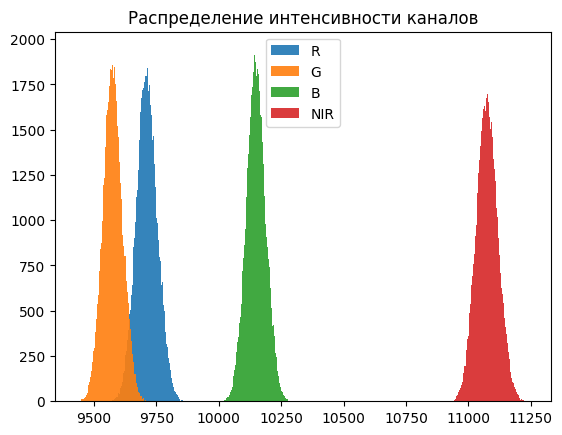

In [17]:
# Гистограмма распределения цветов для каждого канала (R, G, B, NIR)

images_average = np.mean(images, axis=0)
print(images_average.shape)

for i, col in enumerate(['R', 'G', 'B', 'NIR']):
    plt.hist(images_average[i, ...].ravel(), bins=256, alpha=0.9, label=col)
plt.legend(); plt.title("Распределение интенсивности каналов")
plt.show()

### Итог

In [39]:
# Итоговый отчет

df = pd.DataFrame({
    'Метрика': ['Всего изображений', 'Формат изображений', 'Размер изображения', 'Средняя доля облаков', 'Пустых масов', 'Тип масок'],
    'Значение': [len(images), 'TIF', images.shape[2:4], f'{occupancy_perc}%', f'{null_masks_perc}%', 'binary']
})

df

,Метрика,Значение
0,Всего изображений,8400
1,Формат изображений,TIF
2,Размер изображения,"(384, 384)"
3,Средняя доля облаков,93.14%
4,Пустых масов,33.49%
5,Тип масок,binary
